In [1]:
# Monte Carlo Interpretation

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../src/')
from reRoute_Dynamics import Object_Params as op
df = pd.read_pickle('./KC_Example_Data/MC_Saves/1_0.pk')

FileNotFoundError: [Errno 2] No such file or directory: './KC_Example_Data/MC_Saves/1_0.pk'

In [3]:
def convert_to_single_col(df, col):
    l = list(df.apply(lambda x: dict(zip([str(x.name)+" "+i for i in [str(n) for n in list(x[col].keys())]], x[col].values())), axis=1))
    d = {k:v for x in l for k,v in x.items()}
    return pd.Series(d).reset_index(drop=True)

In [26]:
def load_single_trip(trip_path):
    df=pd.read_pickle(trip_path)
    quant = df['95'].mean()
    quant2 = df['97'].mean()
    quant3 = df['99'].mean()
    quant4 = df['99.9'].mean()
    df['BP'] = df['BP'].apply(lambda x: x.to_dict())
    mi_kwh_m = (df['miles']/df['kwh']).mean()
    mi_kwh_s = (df['miles']/df['kwh']).std()
    mi_kwh_min = (df['miles']/df['kwh']).min()
    mi_kwh_max = (df['miles']/df['kwh']).max()
    
    '''
    fig, ax = plt.subplots(1, 1)
    ax.hist(df['tot_time'])
    '''
    
    time_m = df['tot_time'].mean()
    time_sd = df['tot_time'].std()
    time_min = df['tot_time'].min()
    time_max = df['tot_time'].max()

    
    p = convert_to_single_col(df, 'BP')
    t = convert_to_single_col(df, 'dt')
    g = convert_to_single_col(df, 'g')
    v = convert_to_single_col(df, 'v')
    vel = convert_to_single_col(df, 'vel')
    df = pd.concat([p, t, g, v,vel], axis=1)
    df.rename({0:'BP',1:'dt',2:'g',3:'v',4:'vel'}, axis=1,inplace=True)
    time_tot = t.sum()
    

    '''
    fig, ax = plt.subplots(1,1)
    ax.hist(v, weights=t, bins = np.arange(30, 50, 1))
    plt.show()
    '''
    
    volt_indexes = []
    volt_times = []
    power_indexes =[]
    power_times = []
    volt_bins = np.arange(2.9, 3.7, .2)
    power_bins = np.arange(-200000, 500000, 25000)
    for i in range(len(volt_bins)-1):
        binned = df[(df['v'] > volt_bins[i]) & (df['v'] < volt_bins[i+1])]
        frac_time = binned['dt'].sum()/time_tot
        volt_indexes.append((volt_bins[i] + volt_bins[i+1])/2)
        volt_times.append(frac_time)
        
    for i in range(len(power_bins)-1):
        binned = df[(df['BP'] > power_bins[i]) & (df['BP'] < power_bins[i+1])]
        frac_time = binned['dt'].sum()/time_tot
        power_indexes.append((power_bins[i] + power_bins[i+1])/2)
        power_times.append(frac_time)
    
    return {'kwh':[mi_kwh_m, mi_kwh_s, mi_kwh_min, mi_kwh_max],
            'time':[time_m, time_sd,time_min, time_max],
            'grade':[g.mean(), g.std()],
            'vel':[vel.mean(), vel.std()],
            'BP':dict(zip(power_indexes, power_times)),
            'v':dict(zip(volt_indexes, volt_times)),
            '95':quant, '97':quant2,'99':quant3,'99.9':quant4}


In [27]:
def get_kwh_stats(df, key):
    df_key = None
    if type(df[key]) == type([]):
        df_key = pd.Series([df[key]])
    else:
        df_key = df[key]

    minimum = round(df_key.apply(lambda x: x[2]).min(), 4)
    maximum = round(df_key.apply(lambda x: x[3]).max(), 4)
    ave_std = round(df_key.apply(lambda x: x[1]).mean(), 4)
    ave_std_std = round(df_key.apply(lambda x: x[1]).std(), 4)
    ave_mean = round(df_key.apply(lambda x: x[0]).mean(), 4)
    ave_mean_std = round(df_key.apply(lambda x: x[0]).std(), 4)
    return tuple([minimum, maximum, ave_mean, ave_mean_std, ave_std, ave_std_std])

In [28]:
def load_trip_statistics(savepath):
    files = [x for x in os.listdir(savepath) if '.pk' in x]
    unique_shorts = pd.Series(files).apply(lambda x: x.split('_')[0]).unique()
    sim_dict = {}
    for short in unique_shorts[:]:
        print(short)
        simulations = [x for x in files if short + "_" in x]
        for i in range(len(simulations)):
            simulation = simulations[i]
            sim_dict[simulation] = load_single_trip(savepath + simulation)

    return pd.DataFrame(sim_dict).T


In [29]:
trip_stats = load_trip_statistics('../../rRD-MISC/MC_Saves_3/')

45
49
70
8


In [30]:
trip_stats

,kwh,time,grade,vel,BP,v,95,97,99,99.9
45_31045010_1_XDE35.pk,"[0.30427484763592305, 0.04760325431735542, 0.2...","[3278.554879570522, 711.3364200257766, 1908.69...","[0.7151089807625634, 3.6852651202256124]","[8.733372660812197, 3.847920631019103]","{-187500.0: 6.161860409751418e-06, -162500.0: ...","{3.0: 0.0270347592562526, 3.2: 0.7471118435130...",35.40547,36.992753,38.581126,38.894462
45_31045010_1_XDE40.pk,"[0.3057040881005014, 0.047869065201002765, 0.2...","[3279.404533357846, 711.2594607994454, 1908.72...","[0.7150970573819004, 3.685228123670772]","[8.733597970860828, 3.8477246664702527]","{-187500.0: 5.628290560760037e-06, -162500.0: ...","{3.0: 0.02629338517840222, 3.2: 0.748119959451...",35.236793,36.833114,38.411539,38.739194
45_31045010_1_XDE60.pk,"[0.22158341222970118, 0.03320498571940637, 0.1...","[3265.373035228468, 709.5144968270947, 1903.59...","[0.7157584140158192, 3.685772354149914]","[8.690138363867288, 3.823409878281339]","{-187500.0: 0.0011117168952163125, -162500.0: ...","{3.0: 0.08693495580765047, 3.2: 0.674556788195...",47.765132,49.202954,51.115479,52.132616
49_11049009_1_XDE35.pk,"[0.30213256557986123, 0.04631793939777049, 0.2...","[1968.0652098805092, 403.9304819907276, 1157.5...","[0.4129000401774545, 4.147746034432431]","[7.87496026190126, 4.091890599765033]","{-187500.0: 1.0275662742867346e-05, -162500.0:...","{3.0: 0.030249460968866795, 3.2: 0.69262861344...",19.436209,20.181719,20.528964,21.178554
49_11049009_1_XDE40.pk,"[0.3035792619297735, 0.046523833769744186, 0.2...","[1966.51153753724, 403.13036142976244, 1157.58...","[0.4129533527263252, 4.1477208763498]","[7.874944043258933, 4.09158701680591]","{-187500.0: 7.181438347457197e-06, -162500.0: ...","{3.0: 0.02942771908955858, 3.2: 0.693518769187...",19.349407,20.094541,20.445636,21.092336
49_11049009_1_XDE60.pk,"[0.2237820437559857, 0.03224825434847488, 0.16...","[1973.0252262673528, 400.4998263350364, 1163.0...","[0.41361684275002536, 4.1476193672822985]","[7.838923039731124, 4.080625274537958]","{-187500.0: 0.0014711455774506904, -162500.0: ...","{3.0: 0.09004588185938482, 3.2: 0.618215336683...",25.785078,26.265897,27.134969,27.825183
70_20070015_1_XDE35.pk,"[0.34106757269439586, 0.057226570429602414, 0....","[2210.548884859865, 406.72742945151515, 1403.4...","[-0.2699997659850518, 3.7565491845447663]","[7.450684455109376, 4.067623546578651]","{-187500.0: 2.7897429259797087e-06, -162500.0:...","{3.0: 0.032001175040191544, 3.2: 0.65091098564...",19.420594,20.455134,21.431753,22.100205
70_20070015_1_XDE40.pk,"[0.3425571875983828, 0.05754583744393693, 0.23...","[2210.977765627018, 407.21330637394544, 1403.4...","[-0.2699650793103632, 3.7565740273575234]","[7.450752530739658, 4.06758231965498]","{-187500.0: 2.2930217905993376e-06, -162500.0:...","{3.0: 0.031618329643641446, 3.2: 0.65170221598...",19.340703,20.375242,21.354204,22.017342
70_20070015_1_XDE60.pk,"[0.2559354815144063, 0.04174982691520916, 0.17...","[2177.412759656795, 410.965753783689, 1373.284...","[-0.266360796382967, 3.759620505044369]","[7.3889413961204875, 4.04774268108362]","{-187500.0: 0.0011824860466487868, -162500.0: ...","{3.0: 0.08997511968790672, 3.2: 0.567912927713...",25.580099,26.25193,27.607118,28.512215
8_31008006_1_XDE35.pk,"[0.30465358139617166, 0.04253907188822902, 0.2...","[2751.6406143293934, 574.3127045015377, 1594.8...","[0.5922005032983054, 4.4321299604654385]","[8.46804438918619, 3.8455601015227825]","{-187500.0: 4.7866380692431e-06, -162500.0: 0....","{3.0: 0.038767914897037854, 3.2: 0.69157407181...",30.134883,31.380389,32.332351,34.378143


Route: 45
XE35
	milage [mi/kwh] mean/std: 0.30+/-0.05, min: 0.21, max: 0.45
	time [s] mean/std: 3278.55+/-711.34, min: 1908.69, max: 5143.00
	grade mean/std: 0.72+/-3.69
	velocity [m/s] mean/std: 8.73+/-3.85
	capacity needed to achieve 95% of runs: 38.89 kWh, or 11.27% SOC
XE40
	milage [mi/kwh] mean/std: 0.31+/-0.05, min: 0.21, max: 0.45
	time [s] mean/std: 3279.40+/-711.26, min: 1908.72, max: 5142.88
	grade mean/std: 0.72+/-3.69
	velocity [m/s] mean/std: 8.73+/-3.85
	capacity needed to achieve 95% of runs: 38.74 kWh, or 11.23% SOC
XE60
	milage [mi/kwh] mean/std: 0.22+/-0.03, min: 0.16, max: 0.33
	time [s] mean/std: 3265.37+/-709.51, min: 1903.59, max: 5152.92
	grade mean/std: 0.72+/-3.69
	velocity [m/s] mean/std: 8.69+/-3.82
	capacity needed to achieve 95% of runs: 52.13 kWh, or 10.03% SOC


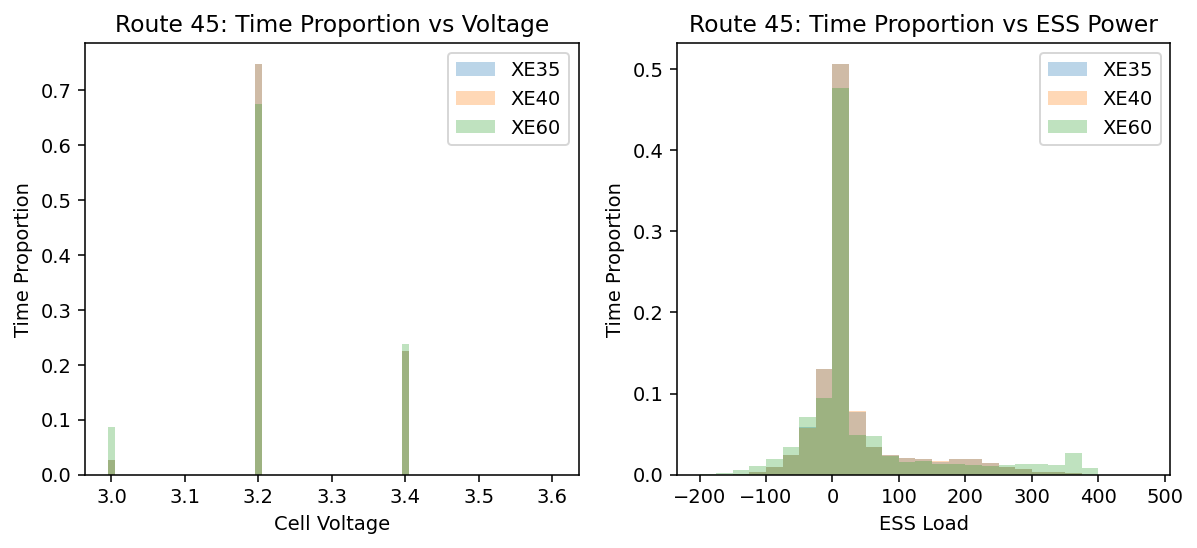

Route: 49
XE35
	milage [mi/kwh] mean/std: 0.30+/-0.05, min: 0.21, max: 0.48
	time [s] mean/std: 1968.07+/-403.93, min: 1157.57, max: 3022.18
	grade mean/std: 0.41+/-4.15
	velocity [m/s] mean/std: 7.87+/-4.09
	capacity needed to achieve 95% of runs: 21.18 kWh, or 6.14% SOC
XE40
	milage [mi/kwh] mean/std: 0.30+/-0.05, min: 0.21, max: 0.48
	time [s] mean/std: 1966.51+/-403.13, min: 1157.59, max: 3022.12
	grade mean/std: 0.41+/-4.15
	velocity [m/s] mean/std: 7.87+/-4.09
	capacity needed to achieve 95% of runs: 21.09 kWh, or 6.11% SOC
XE60
	milage [mi/kwh] mean/std: 0.22+/-0.03, min: 0.16, max: 0.35
	time [s] mean/std: 1973.03+/-400.50, min: 1163.04, max: 3015.37
	grade mean/std: 0.41+/-4.15
	velocity [m/s] mean/std: 7.84+/-4.08
	capacity needed to achieve 95% of runs: 27.83 kWh, or 5.35% SOC


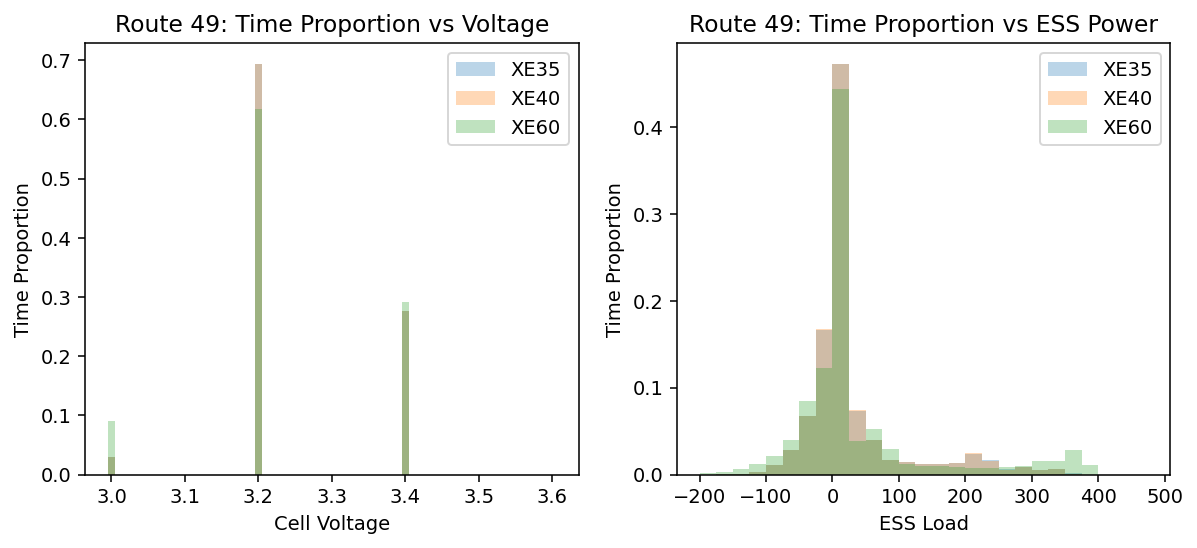

Route: 70
XE35
	milage [mi/kwh] mean/std: 0.34+/-0.06, min: 0.23, max: 0.52
	time [s] mean/std: 2210.55+/-406.73, min: 1403.46, max: 3357.50
	grade mean/std: -0.27+/-3.76
	velocity [m/s] mean/std: 7.45+/-4.07
	capacity needed to achieve 95% of runs: 22.10 kWh, or 6.41% SOC
XE40
	milage [mi/kwh] mean/std: 0.34+/-0.06, min: 0.23, max: 0.52
	time [s] mean/std: 2210.98+/-407.21, min: 1403.45, max: 3357.40
	grade mean/std: -0.27+/-3.76
	velocity [m/s] mean/std: 7.45+/-4.07
	capacity needed to achieve 95% of runs: 22.02 kWh, or 6.38% SOC
XE60
	milage [mi/kwh] mean/std: 0.26+/-0.04, min: 0.18, max: 0.39
	time [s] mean/std: 2177.41+/-410.97, min: 1373.28, max: 3371.94
	grade mean/std: -0.27+/-3.76
	velocity [m/s] mean/std: 7.39+/-4.05
	capacity needed to achieve 95% of runs: 28.51 kWh, or 5.48% SOC


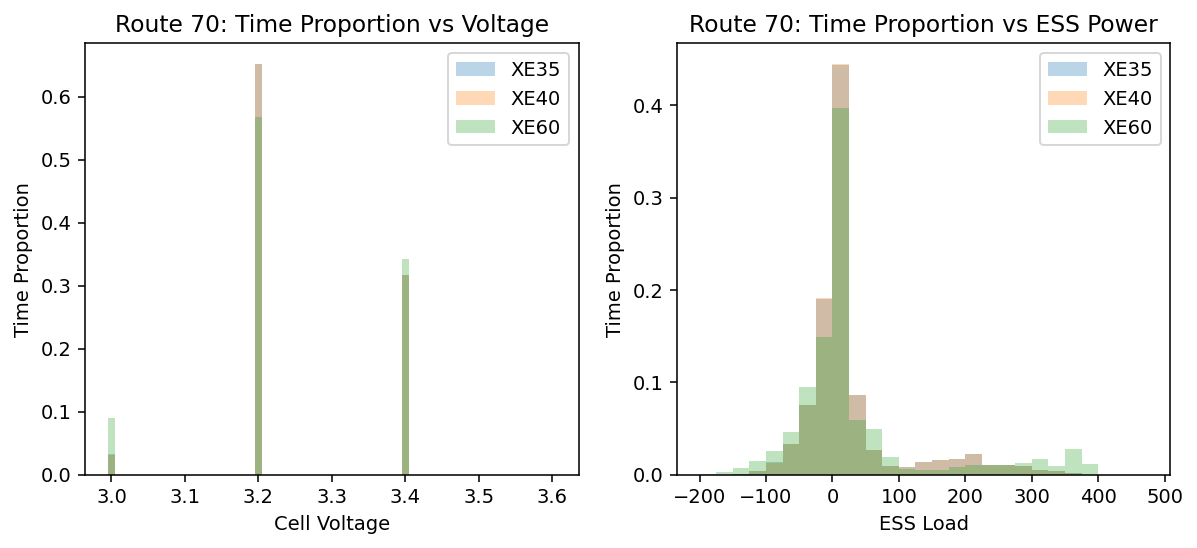

Route: 8
XE35
	milage [mi/kwh] mean/std: 0.30+/-0.04, min: 0.20, max: 0.44
	time [s] mean/std: 2751.64+/-574.31, min: 1594.84, max: 4295.31
	grade mean/std: 0.59+/-4.43
	velocity [m/s] mean/std: 8.47+/-3.85
	capacity needed to achieve 95% of runs: 34.38 kWh, or 9.96% SOC
XE40
	milage [mi/kwh] mean/std: 0.31+/-0.04, min: 0.21, max: 0.45
	time [s] mean/std: 2752.36+/-573.98, min: 1594.84, max: 4294.46
	grade mean/std: 0.59+/-4.43
	velocity [m/s] mean/std: 8.47+/-3.85
	capacity needed to achieve 95% of runs: 34.24 kWh, or 9.93% SOC
XE60
	milage [mi/kwh] mean/std: 0.22+/-0.03, min: 0.16, max: 0.31
	time [s] mean/std: 2740.25+/-568.50, min: 1603.82, max: 4328.95
	grade mean/std: 0.59+/-4.43
	velocity [m/s] mean/std: 8.41+/-3.81
	capacity needed to achieve 95% of runs: 43.80 kWh, or 8.42% SOC


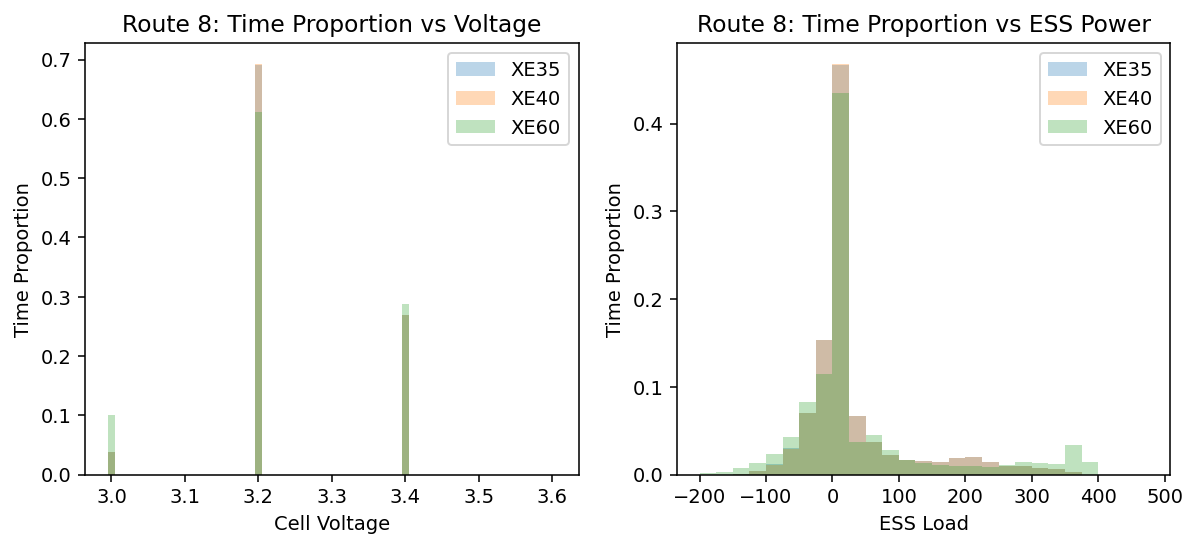

In [31]:
unique_shorts = pd.Series(list(trip_stats.index)).apply(lambda x: x.split('_')[0]).unique()
capacity = {"XE35":345,"XE40":345,"XE60":520}
for unique_short in unique_shorts:
    f_trips = trip_stats[pd.Series(list(trip_stats.index), index=list(trip_stats.index)).apply(lambda x: x.split('_')[0] == unique_short)]
    fig, ax = plt.subplots(1, 2, figsize = (10, 4), dpi=140)
    print("Route: {}".format(unique_short))
    for col, row in f_trips.iterrows():
        busname = col.split("_")[-1].split(".")[0].replace("D","")
        print(busname)
        print("\tmilage [mi/kwh] mean/std: {:.2f}+/-{:.2f}, min: {:.2f}, max: {:.2f}".format(*tuple(row['kwh'])))
        print("\ttime [s] mean/std: {:.2f}+/-{:.2f}, min: {:.2f}, max: {:.2f}".format(*tuple(row['time'])))
        print("\tgrade mean/std: {:.2f}+/-{:.2f}".format(*tuple(row['grade'])))
        print("\tvelocity [m/s] mean/std: {:.2f}+/-{:.2f}".format(*tuple(row['vel'])))
        print("\tcapacity needed to achieve 95% of runs: {:.2f} kWh, or {:.2f}% SOC".format(row['99.9'], row['99.9']/capacity[busname]*100))
        ax[0].bar(row['v'].keys(),row['v'].values(), alpha=.3, width = .01)
        ax[1].bar(np.asarray(list(row['BP'].keys()))/1000, row['BP'].values(), alpha=.3, width=25)
        
    legend = list(pd.Series(f_trips.index).apply(lambda x: x.split("_")[-1].split(".")[0].replace("D","")))
    ax[0].legend(legend)
    ax[1].legend(legend)
    ax[0].set_title("Route {}: Time Proportion vs Voltage".format(unique_short))
    ax[0].set_xlabel("Cell Voltage")
    ax[0].set_ylabel("Time Proportion")
    ax[1].set_title("Route {}: Time Proportion vs ESS Power".format(unique_short))
    ax[1].set_xlabel("ESS Load")
    ax[1].set_ylabel("Time Proportion")
    plt.show()

In [12]:
=

,kwh,time,grade,vel,BP,v,95,97,99,99.9
8_31008006_1_XDE35.pk,"[0.30465358139617166, 0.04253907188822902, 0.2...","[2751.6406143293934, 574.3127045015377, 1594.8...","[0.5922005032983054, 4.4321299604654385]","[8.46804438918619, 3.8455601015227825]","{-187500.0: 4.7866380692431e-06, -162500.0: 0....","{3.005: 0.0, 3.0149999999999997: 0.0, 3.024999...",30.134883,31.380389,32.332351,34.378143
8_31008006_1_XDE40.pk,"[0.30609487538560826, 0.04281046059545403, 0.2...","[2752.36274202292, 573.9804647452228, 1594.843...","[0.5921535755306808, 4.432112587899931]","[8.467906366427494, 3.8457578711637397]","{-187500.0: 4.034078590590923e-06, -162500.0: ...","{3.005: 0.0, 3.0149999999999997: 0.0, 3.024999...",29.997347,31.243718,32.234368,34.243455
8_31008006_1_XDE60.pk,"[0.2249674936652579, 0.028278800950227456, 0.1...","[2740.24592576617, 568.4957705114648, 1603.818...","[0.5908826507590702, 4.432151394551619]","[8.414089796210437, 3.8075057503349363]","{-187500.0: 0.001677188729627009, -162500.0: 0...","{3.005: 0.0, 3.0149999999999997: 0.0, 3.024999...",39.396508,40.779466,42.145585,43.801317


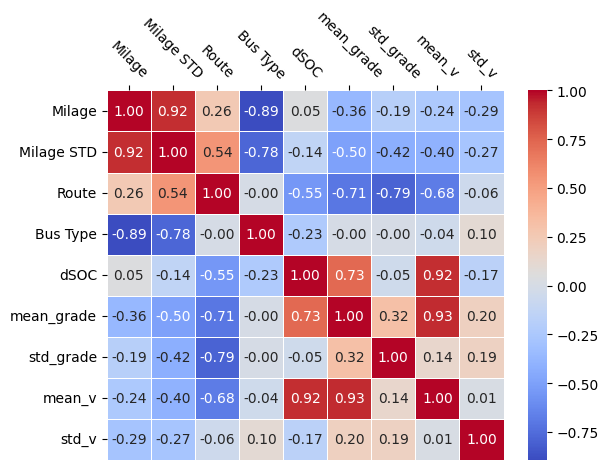

In [40]:
import seaborn as sns
matrix = np.triu(pd.read_csv("../../rRD-MISC/MC_Saves_3/summarized_rundata.csv").corr())
h = sns.heatmap(pd.read_csv("../../rRD-MISC/MC_Saves_3/summarized_rundata.csv").corr(), annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm')
h.axes.xaxis.set_ticks_position("top")
h.axes.tick_params(axis='x', labelrotation=-45)

In [14]:
def plot_voltage(df):
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 4), dpi=140)
    vdat = pd.DataFrame(list(df['v']))
    means = vdat.mean().values
    stds = vdat.std().values
    ax[0].errorbar(vdat.columns, means, yerr=stds, fmt='o', capsize = 10)
    ax[0].bar(vdat.columns, means, alpha=.3, width = .1)
    major_ticks = np.arange(2, 4, .1)

    ax[0].set_xticks(major_ticks)
    ax[0].set_xticks(ticks = ax[0].get_xticks(), labels=ax[0].get_xticklabels(), rotation=-45)
    #ax[0].grid()
    ax[0].set_xlabel('Cell Voltage [v]')
    ax[0].set_ylabel('Fraction of Time')
    ax[0].set_title('Time-proportional module voltage & Power distribution')
    # For a route's inbound or outbound direction, these are the aggregated monte-carlo distributions of module voltage.
    
    bdat = pd.DataFrame(list(df['BP']))
    means = bdat.mean().values
    stds = bdat.std().values
    ax[1].errorbar(bdat.columns/1000, means, yerr=stds, fmt='o', capsize = 10)
    ax[1].bar(bdat.columns/1000, means, alpha=.3, width=50)
    major_ticks = np.arange(-200000/1000, 500000/1000, 50000/1000)

    ax[1].set_xticks(major_ticks)
    ax[1].set_xticks(ticks = ax[1].get_xticks(), labels=ax[1].get_xticklabels(), rotation=-45)
    ax[1].grid()
    ax[1].set_xlabel('ESS Power [kW]')
    ax[1].set_ylabel('Fraction of Time')
    # For a route's inbound or outbound direction, these are the aggregated monte-carlo distributions of module load.
    
    
    plt.show()
    return plt

In [130]:
def interpret_trip_statistics(df):
    unique_shorts = pd.Series(df.index).apply(lambda x: x.split('_')[0]).unique()
    for shortname in unique_shorts:
        sdf = df[pd.Series(df.index, index=df.index).apply(lambda x: x.split('_')[0]) == shortname]
        for col, row in sdf.iterrows():
            print(row['kwh'])
            tup = (shortname,) + get_kwh_stats(row, 'kwh')
            print("Route {} Inbound: \n\tMilage Min: {} kWh, Max: {} kWh, Average Mean: {}+/-{} kWh, Average STD: {}+/-{} kWh".format(*tup))
            tup = get_kwh_stats(row, 'time')
            print('\tTime Min: {} s, Max: {} s, Average Mean: {}+/-{} s, Average STD: {}+/-{} s'.format(*tup))
            tup = (shortname,) + get_kwh_stats(row, 'kwh')
            plot_voltage(row)
            print()
        '''
        #i_df = sdf[pd.Series(sdf.index, index=sdf.index).apply(lambda x: int(x.split('_')[1].split('.')[0])%2 == 0)]
        #o_df = sdf[pd.Series(sdf.index, index=sdf.index).apply(lambda x: int(x.split('_')[1].split('.')[0])%2 == 1)]
        
        
        tup = (shortname,) + get_kwh_stats(i_df, 'kwh')
        print("Route {} Inbound: \n\tMilage Min: {} kWh, Max: {} kWh, Average Mean: {}+/-{} kWh, Average STD: {}+/-{} kWh".format(*tup))
        tup = get_kwh_stats(i_df, 'time')
        print('\tTime Min: {} s, Max: {} s, Average Mean: {}+/-{} s, Average STD: {}+/-{} s'.format(*tup))
        tup = (shortname,) + get_kwh_stats(o_df, 'kwh')
        plot_voltage(i_df)
        print("Route {} Outbound: \n\tMilage Min: {} kWh, Max: {} kWh, Average Mean: {}+/-{} kWh, Average STD: {}+/-{} kWh".format(*tup))
        tup =  get_kwh_stats(o_df, 'time')
        print('\tTime Min: {} s, Max: {} s, Average Mean: {}+/-{} s, Average STD: {}+/-{} s'.format(*tup))
        plot_voltage(o_df)
        '''
        print()

[np.float64(0.3776605058552544), np.float64(0.07133794453560545), np.float64(0.23769643505523697), np.float64(0.573035382949408)]
Route 45 Inbound: 
	Milage Min: 0.2377 kWh, Max: 0.573 kWh, Average Mean: 0.3777+/-nan kWh, Average STD: 0.0713+/-nan kWh
	Time Min: 1580.3954 s, Max: 5089.1053 s, Average Mean: 3015.167+/-nan s, Average STD: 689.8736+/-nan s


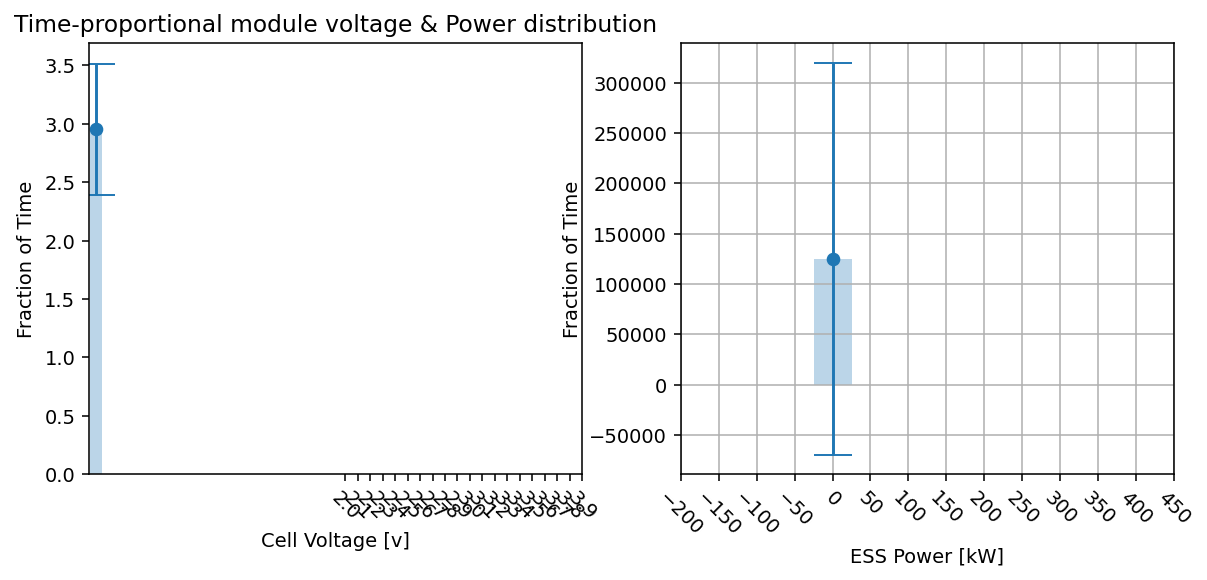


[np.float64(0.3793626968620922), np.float64(0.07173142024204586), np.float64(0.23860327369951734), np.float64(0.5757486783948417)]
Route 45 Inbound: 
	Milage Min: 0.2386 kWh, Max: 0.5757 kWh, Average Mean: 0.3794+/-nan kWh, Average STD: 0.0717+/-nan kWh
	Time Min: 1580.3664 s, Max: 5090.2109 s, Average Mean: 3015.7002+/-nan s, Average STD: 690.2327+/-nan s


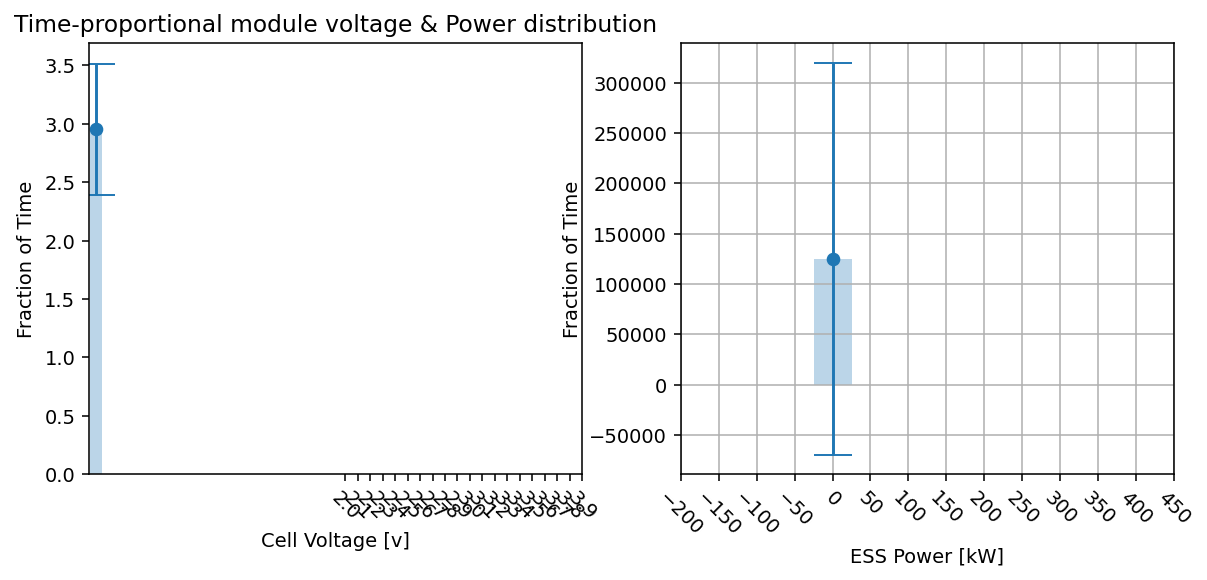


[np.float64(0.2797250813938869), np.float64(0.05154506158676815), np.float64(0.18455384986356566), np.float64(0.42146323910457323)]
Route 45 Inbound: 
	Milage Min: 0.1846 kWh, Max: 0.4215 kWh, Average Mean: 0.2797+/-nan kWh, Average STD: 0.0515+/-nan kWh
	Time Min: 1603.9311 s, Max: 4953.5192 s, Average Mean: 3019.9919+/-nan s, Average STD: 688.6804+/-nan s


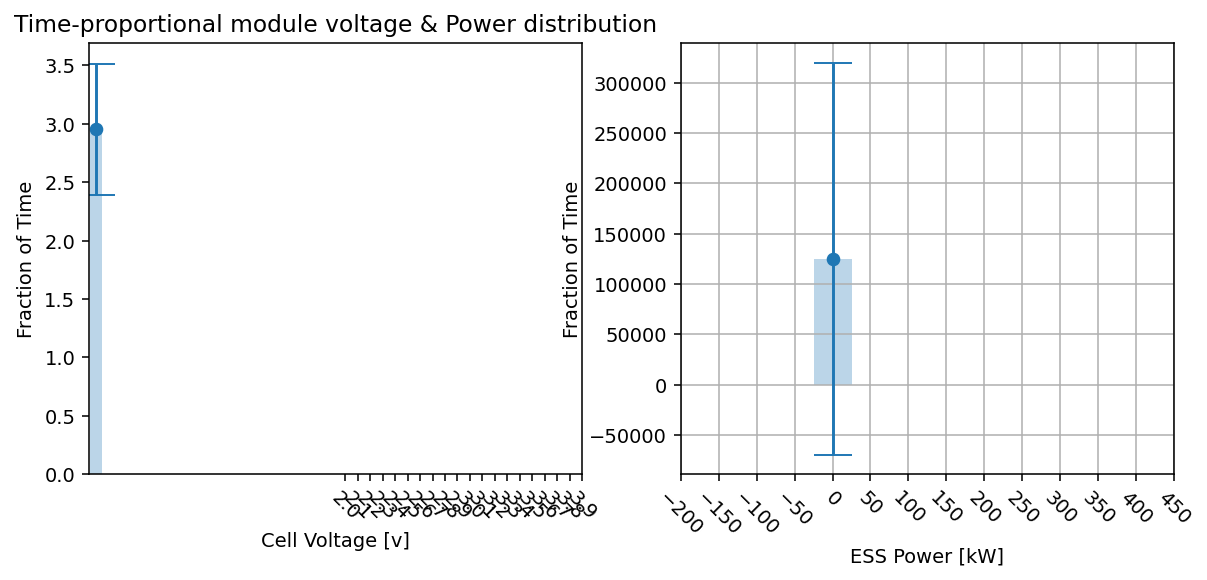



[np.float64(0.380671670043547), np.float64(0.0694402006106774), np.float64(0.23905387719278326), np.float64(0.5661922203299321)]
Route 70 Inbound: 
	Milage Min: 0.2391 kWh, Max: 0.5662 kWh, Average Mean: 0.3807+/-nan kWh, Average STD: 0.0694+/-nan kWh
	Time Min: 1599.249 s, Max: 4731.2326 s, Average Mean: 2991.3183+/-nan s, Average STD: 654.7416+/-nan s


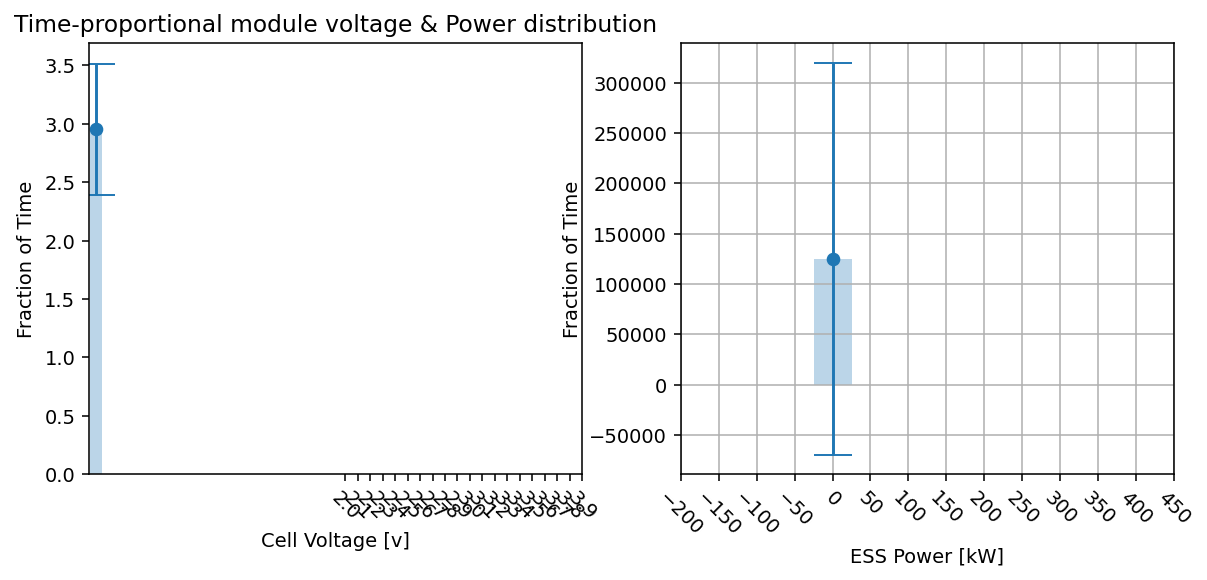


[np.float64(0.3824340879187114), np.float64(0.06979342208438566), np.float64(0.23996412199518055), np.float64(0.5689567012726974)]
Route 70 Inbound: 
	Milage Min: 0.24 kWh, Max: 0.569 kWh, Average Mean: 0.3824+/-nan kWh, Average STD: 0.0698+/-nan kWh
	Time Min: 1599.2233 s, Max: 4734.518 s, Average Mean: 2990.5131+/-nan s, Average STD: 654.3991+/-nan s


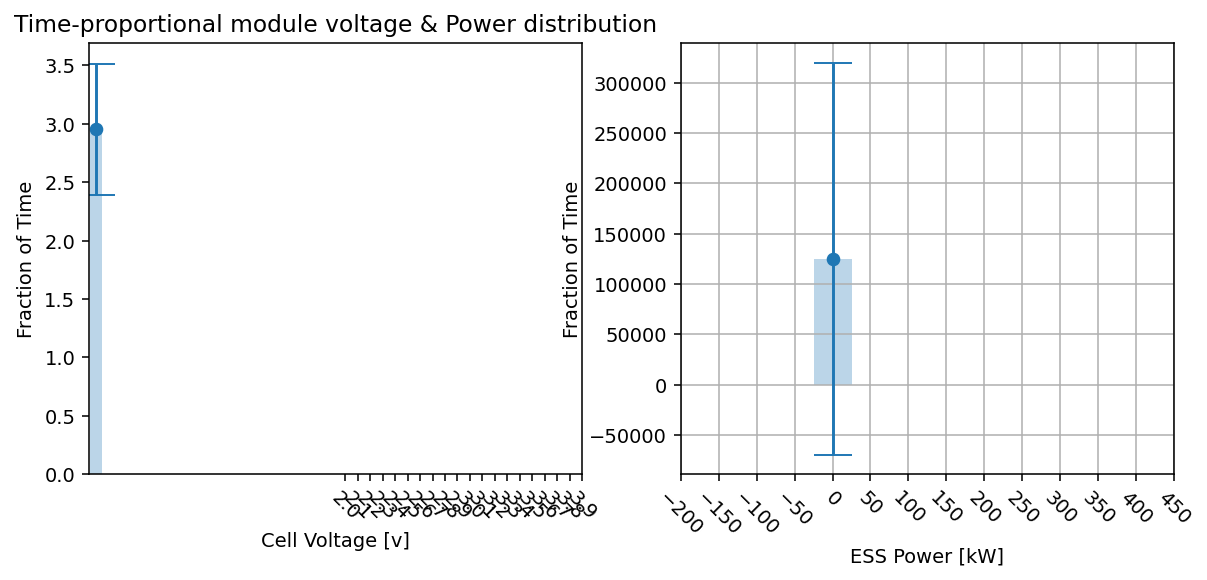


[np.float64(0.28230039510186494), np.float64(0.049948013297657655), np.float64(0.18704438885843858), np.float64(0.4132564792373872)]
Route 70 Inbound: 
	Milage Min: 0.187 kWh, Max: 0.4133 kWh, Average Mean: 0.2823+/-nan kWh, Average STD: 0.0499+/-nan kWh
	Time Min: 1595.071 s, Max: 4791.3953 s, Average Mean: 2990.8826+/-nan s, Average STD: 648.8275+/-nan s


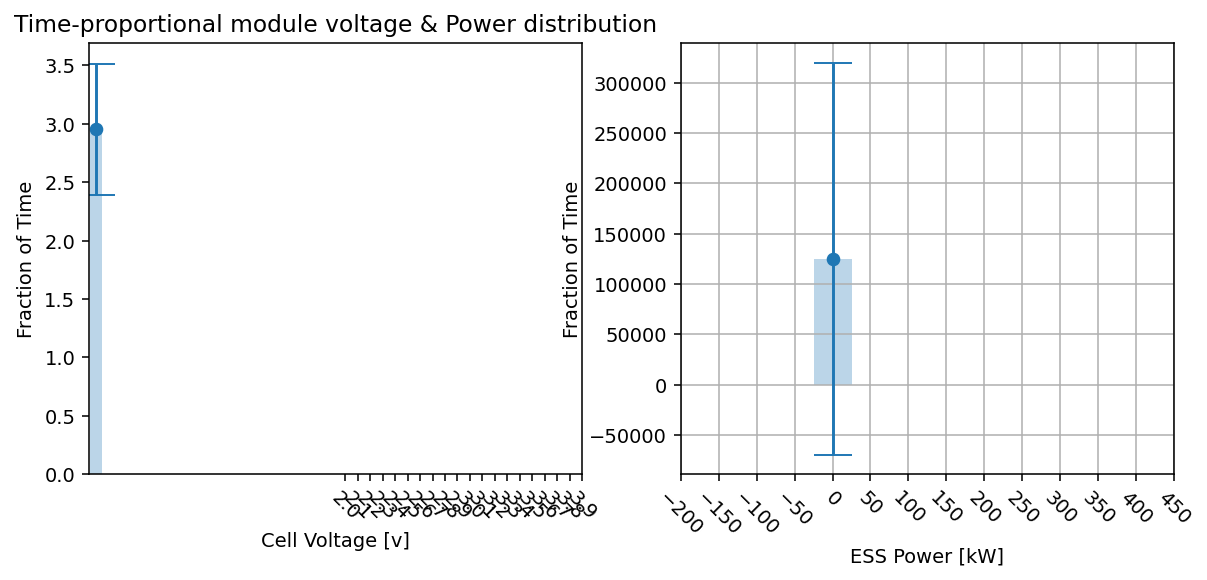

In [131]:
interpret_trip_statistics(trip_stats)

In [453]:
trip_stats.to_pickle('trip_statistics.pk')

In [ ]:
XDE60_ESS = op.ESS(motor_eff = .93, # @Gallet. No clear source on where these drivetrain, inverter, and motor efficiencies came from. Can't find TB200 specs yet.
                   inverter_eff = .88, # @Gallet
                   aux_eff = .89, # Assumption.
                   regen_eff = .54, # Assumption.
                   simple_load = 8000,
                   max_regen = -200000, #w, finally, some good sourcable values.@XDE35_Manual
                   module_struct = (12,8),
                   bus_struct = (16,40))


XDE60 = op.Bus(bus_mass = 20638, #kg, @NF_Xcelsior
               frontal_width = 2.6, #m,@NF_Xcelsior
               frontal_height = 3.38, #m, @NF_Xcelsior
               drag_coeff = .7, # Unitless. Many suspect papers cite .6, but best bet was one citing ORNL bus database saying .79, @Gao_Et_Al
               friction_coeff = .01, # unitless, otherwise known as rolling resistance. @Rolling_Resistance
               braking_accel = 1.5, #1.5m/s^2, handbrake required to stop from 20 mph, over no set distance. emergency brake must be capable of up to 6.5m/s^2 (20 mph over 20 ft).@APTA_Braking_Standards
               br_factor = .5, # driver braking aggression. Variable based on driver.
               i_factor = 1.1, # unitless, accounts for wheels, driveshaft, etc, cited from @Gallet
                               # however, there is no substantive explanation as to how it was calculated/obtained.
               max_dist = 304.8, # m, expected stopping distance for a bust from 60 mph calculated from google map offramp length measurements of I-5.
               max_acc = .4, # m/s^2, chosen due to it being a decent extension of existing drive cycle. subject to change.
               max_dt = .5, #s, timestep for that extension. 
               max_P = 300000 # W, @Siemens_Traction_Motor 
              )
    
XDE60_ESS.calc_voltage_simple(XDE60_ESS.calc_instance_power(68440000))

XDE40_ESS =  op.ESS(motor_eff = .93, # @Gallet. No clear source on where these drivetrain, inverter, and motor efficiencies came from. Can't find TB200 specs yet.
                   inverter_eff = .88, # @Gallet
                   aux_eff = .89, # Assumption.
                   regen_eff = .54, # Assumption.
                   simple_load = 8000,
                   max_regen = -200000, #w, finally, some good sourcable values.@XDE35_Manual
                   module_struct = (12,8),
                   bus_struct = (16,32)
                   
                   # W @Siemens_Traction_Motor
                  )

XDE35_ESS =  op.ESS(motor_eff = .93, # @Gallet. No clear source on where these drivetrain, inverter, and motor efficiencies came from. Can't find TB200 specs yet.
                   inverter_eff = .88, # @Gallet
                   aux_eff = .89, # Assumption.
                   regen_eff = .54, # Assumption.
                   simple_load = 8000,
                   max_regen = -200000, #w, finally, some good sourcable values.@XDE35_Manual
                   module_struct = (12,8),
                   bus_struct = (16,32)
                   
                   # W @Siemens_Traction_Motor
                  )



In [27]:
import ast
import random
def optimizefunc(func, ranges):
    '''
    optimizefunc takes a function with n parameters, and a set of n ranges for each parameter,
    and attempts to minimize the return value of the function. 
    '''
    # Set seed for optimization randomization
    random.seed(42)
    
    # Max iterations is 30
    max_iterations=1000
    iterations = 0
    
    rep_iterations = 0
    # Get number of dimensions for hyper-triangle
    ndim = 1+ len(ranges)
    
    # Dictionary for the points
    point_dict = {}
    lowest_max = (9999, 0)
    # render the first point set, this could be done with multiprocessing
    for i in range(ndim):
        args = []
        for j in range(len(ranges)):
            #print(ranges[j])
            arg = random.uniform(*ranges[j])
            args.append(arg)
        result = func(*tuple(args))
        point_dict[str(args)]=result

    # Loop the number of times specified
    while iterations < max_iterations:
        
        print("Evaluating literals...", end='\r')
        
        # get the furthest point's parameters
        furthest_pt = ast.literal_eval(max(point_dict, key=point_dict.get))
        furthest_val = point_dict[max(point_dict, key=point_dict.get)]
        
        # Check if the lowest max value is higher than the current
        if furthest_val < lowest_max[0]:
            lowest_max = (furthest_val, furthest_pt)

        # remove it from the dict
        del point_dict[max(point_dict, key=point_dict.get)]
        
        print("Loading hyperplane params...", end='\r')
        # get the vectors for the hyperplane
        hyperplane_vectors = list(point_dict.keys())
        
        # Convert them to actual vectors
        for i in range(len(hyperplane_vectors)):
            hyperplane_vectors[i] = ast.literal_eval(hyperplane_vectors[i])
        
        print("Calculating hyperplane...", end='\r')
        # get the hyperplane equation
        hyperplane_eqn = np.linalg.solve(hyperplane_vectors, [-1]*len(hyperplane_vectors))
        
        print("Evaluating hyperplane normal...", end='\r')
        # get the hyperplane normal
        hyperplane_normal_len = np.sqrt(sum(np.square(hyperplane_eqn)))
        
        # get the normalized hyperplane vector
        normalized_vector = hyperplane_eqn/hyperplane_normal_len
        
        print("Calculating Mirror Point...", end='\r')
        # Get the sign distance for the furthest point
        signdist = sum(normalized_vector*furthest_pt)
        
        # Get the mirrored version of that point
        mirrorpt = furthest_pt -2*normalized_vector*signdist
        
        mirrorpt = ensure_in_range(mirrorpt, ranges)
        
        print("Calculating Centroid...", end='\r')
        # Calculate the centroid of the hyperplane and mirror
        centroid = (sum([np.asarray(ls) for ls in hyperplane_vectors]) + mirrorpt)/(len(hyperplane_vectors)+1)
        centroid = ensure_in_range(centroid, ranges)
        
        print("Running Mirror Point...", end='\r')
        # run the function with the mirror and the centroid
        mir = func(*mirrorpt)
        print("Running Centroid Point...", end='\r')
        cent = func(*centroid)
        
        # if the mirror result is lower than the centroid, keep it
        if mir < cent:
            point_dict[str(mirrorpt.tolist())] = mir
            
        # otherwise, keep the centroid result
        else:
            point_dict[str(centroid.tolist())] = cent
        
        if point_dict[max(point_dict, key=point_dict.get)] == furthest_val:
            rep_iterations += 1
        
        if rep_iterations > 2: 
            closest_key = min(point_dict, key=point_dict.get)
            closest_val = point_dict[closest_key]
            point_dict = {}
            point_dict[closest_key] = closest_val
            for i in range(ndim-1):
                args = []
                for j in range(len(ranges)):
                    #print(ranges[j])
                    arg = random.uniform(*ranges[j])
                    args.append(arg)
                result = func(*tuple(args))
                point_dict[str(args)]=result
            rep_iterations = 0
        # update iterations. 
        #print(iterations, point_dict[min(point_dict, key=point_dict.get)], point_dict[max(point_dict, key=point_dict.get)])
        iterations+=1
    
    # return the lowest value parameter set found. 
    print(lowest_max)
    return min(point_dict, key=point_dict.get), point_dict[min(point_dict, key=point_dict.get)]

def ensure_in_range(point, point_bounds):
    '''
    verifies that a point in n dimensions lies within the n bounds [(min, max) * n],
    and if it isnt, set the point to be within the bounds.
    '''
    for i in range(len(point)):
        param_bounds = point_bounds[i]
        if point[i] < min(param_bounds):
            point[i] = min(param_bounds)
        elif point[i]> max(param_bounds):
            point[i] = max(param_bounds)
        else:
            point[i]=point[i]
    return point

In [41]:
from reRoute_Dynamics import Physics_Engine as pe

def buspower_brake(ve, dx, g, b, wb, ws):
    return (XDE60_ESS.calc_voltage_simple(XDE60_ESS.calc_instance_power(
             pe.brake(ve,
                     XDE60.mass,
                     dx,
                     pe.calculate_grade_force(g, XDE60.mass, XDE60.Cf),
                     pe.calculate_wind_force(b, ve, wb, ws, drag_coeff = XDE60.Cd, frontal_area = XDE60.area),
                     XDE60.a_br,
                     XDE60.f_br,
                     XDE60.f_i,
                     XDE60.dmax)['P'])))

def buspower_accel(ve, dx, g, b, wb, ws):
    return (XDE60_ESS.calc_voltage_simple(XDE60_ESS.calc_instance_power(
             pe.accelerate(ve,
                     XDE60.mass,
                     dx,
                     pe.calculate_grade_force(g, XDE60.mass, XDE60.Cf),
                     pe.calculate_wind_force(b, ve, wb, ws, drag_coeff = XDE60.Cd, frontal_area = XDE60.area),
                     braking_acceleration = XDE60.a_br,
                     braking_factor = XDE60.f_br,
                     inertial_factor = XDE60.f_i,
                     max_timestep = XDE60.dt_max,
                     max_power = XDE60.P_max)['P'])))

def buspower_maintain(ve, dx, g, b, wb, ws):
    return (XDE60_ESS.calc_voltage_simple(XDE60_ESS.calc_instance_power(
             pe.maintain(ve,
                     XDE60.mass,
                     dx,
                     pe.calculate_grade_force(g, XDE60.mass, XDE60.Cf),
                     pe.calculate_wind_force(b, ve, wb, ws, drag_coeff = XDE60.Cd, frontal_area = XDE60.area),
                     braking_acceleration = XDE60.a_br,
                     braking_factor = XDE60.f_br,
                     inertial_factor = XDE60.f_i,
                     max_power = XDE60.P_max)['P'])))

In [47]:
optimizefunc(buspower_accel, [(-500, 500),(-20, 20),(-10, 10),(0, 360), (0, 360), (0, 15)])

C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:487: RuntimeWarning: invalid value encountered in sqrt
  v_f = np.sqrt(2*travel_distance*a + velocity**2)


C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a


C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid val

C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:487: RuntimeWarning: invalid value encountered in sqrt
  v_f = np.sqrt(2*travel_distance*a + velocity**2)


C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a


(np.float64(36.94637861003723), [139.4267984578837, -18.99956979109332, -4.499413632617615, 80.3558657335762, 265.1296370990445, 10.150492311343669])


('[430.8259047499531, 13.567051504464224, 2.999213685883632, 284.8970294935834, 49.5358515813138, 4.303190959699022]',
 np.float64(36.94637861003723))

In [102]:
load_single_trip('./KC_Example_Data/MC_Saves/1_0.pk')

{'kwh': [np.float64(0.3718645560766517),
  np.float64(0.07182303563537704),
  np.float64(0.23209010154487017),
  np.float64(0.6544297962466623)],
 'time': [np.float64(1950.571278046464),
  np.float64(457.78507290704687),
  np.float64(1050.4576334873573),
  np.float64(3437.4373364750145)],
 'grade': [np.float64(-0.6644217780518513), np.float64(3.8537393178248633)],
 'vel': [np.float64(7.871805505318005), np.float64(3.9765109471094187)],
 'BP': [array([1.91545118e-08, 4.33902329e-07, 3.21032692e-06, 1.14584608e-05,
         7.13713887e-07, 3.96673044e-07, 8.22784116e-07, 6.96705433e-07,
         1.27393074e-07, 5.93430073e-08]),
  array([-179670.15704976, -123924.00265817,  -68177.84826658,
          -12431.693875  ,   43314.46051659,   99060.61490818,
          154806.76929977,  210552.92369136,  266299.07808295,
          322045.23247454,  377791.38686612]),
  <BarContainer object of 10 artists>],
 'v': [array([0.02360938, 0.15143933, 0.06293114, 0.10579587, 0.41463091,
         0.6434

In [100]:
df['BP'].apply(lambda x: x.to_dict())

0      {0: nan, 1: 22805.341787578058, 2: -12475.1304...
1      {0: nan, 1: 18660.39796735334, 2: 117571.04659...
2      {0: nan, 1: 18029.17611600489, 2: -16807.42715...
3      {0: nan, 1: 22881.519423945087, 2: 121974.1477...
4      {0: nan, 1: 17849.616363439403, 2: 118374.8514...
                             ...                        
295    {0: nan, 1: 17548.935154282168, 2: -17678.6221...
296    {0: nan, 1: 16688.260996978795, 2: 115780.8893...
297    {0: nan, 1: 15389.16151102995, 2: 114875.57799...
298    {0: nan, 1: 20892.755379001268, 2: 119985.3837...
299    {0: nan, 1: 18218.374994176018, 2: 119073.9352...
Name: BP, Length: 300, dtype: object